# Apr ??, 2022 ()

**Motivation**: Make group plots (GABAN) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [51]:
def quick_show(tr1, tr2, vmin=0.1, vmax=None, cmap='magma'):
    num = max(len(tr1['proj-top']), len(tr2['proj-top']))
    fig, axes = create_figure(2, num, (13, 4))
    for i in range(num):

        ax = axes[0, i]
        if i >= len(tr1['proj-top']):
            ax.remove()
        else:
            ax.imshow(mwh(tr1['top'] == 0, tr1['top']), cmap='Greys_r')
            if np.nanmax(tr1['proj-top'][i]) > 1:
                _cmap = 'Accent_r'
                _vmax = None
            else:
                _cmap = cmap
                _vmax = vmax
            ax.imshow(mwh(tr1['proj-top'][i] < vmin, tr1['proj-top'][i]), cmap=_cmap, vmin=vmin, vmax=_vmax)

        ax = axes[1, i]
        if i >= len(tr2['proj-top']):
            ax.remove()
        else:
            ax.imshow(mwh(tr2['top'] == 0, tr2['top']), cmap='Greys_r')
            if np.nanmax(tr2['proj-top'][i]) > 1:
                _cmap = 'Accent_r'
                _vmax = None
            else:
                _cmap = cmap
                _vmax = vmax
            ax.imshow(mwh(tr2['proj-top'][i] < vmin, tr2['proj-top'][i]), cmap=_cmap, vmin=vmin, vmax=_vmax)

    remove_ticks(axes)
    plt.show()

## Fig dir

In [3]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Mice

In [4]:
mice = Mice(512)
mice.setup_func_data('rest')

In [6]:
num_k, p = 8, 24
perc = f'p{p}-sample'

key = mice.get_key(10, 3, 1)
sv = SVINET(mice, num_k, perc, key, 'ca2')

current expt: 'p24-sample'

In [7]:
_ = sv.load_runs()

[PROGRESS] experiment loaded: 'k = 8, p24-sample',  total # runs:  735

[PROGRESS] some runs were excluded:     233 x k = 7,  31 x k = 6

In [24]:
last_perf = collections.defaultdict(list)
for run_name, run_dict in sv._runs[sv.perc].items():
    for lbl, vals in run_dict['valid'].items():
        if 'nll' not in lbl:
            continue
        last_perf[lbl].append(run_dict['valid'][lbl][-1])
rank_perf = {lbl: sp_stats.rankdata(x) for lbl, x in last_perf.items()}

In [27]:
np.where(rank_perf['nll'] == 1)[0]

array([227])

<matplotlib.lines.Line2D object at 0x7fe64d6cf0d0>

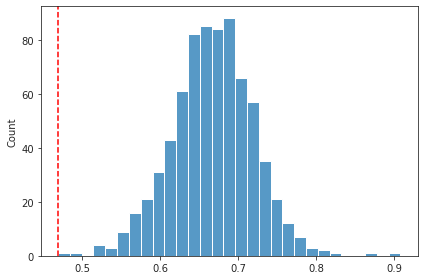

In [33]:
fig, ax = create_figure()
sns.histplot(last_perf['nll'])
ax.axvline(last_perf['nll'][227], color='r', ls='--')

<AxesSubplot:ylabel='Count'>

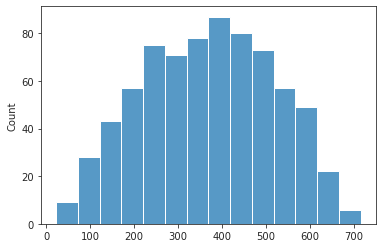

In [36]:
x = np.concatenate([x.reshape(1, -1) for x in rank_perf.values()]).mean(0)
sns.histplot(x)

In [53]:
best = np.argmax(x)
best

43

In [54]:
{lbl: vals[best] for lbl, vals in last_perf.items()}

{
    'nll': 0.779140732,
    'nll_link': 0.161587212,
    'nll_nonlink': 1.396694252,
    'nll_sparse': 0.461802415,
    'nll_sparse_link': 0.122310504,
    'nll_sparse_nonlink': 0.339491911
}

In [55]:
{lbl: vals[best] for lbl, vals in rank_perf.items()}

{
    'nll': 725.0,
    'nll_link': 720.0,
    'nll_nonlink': 698.0,
    'nll_sparse': 733.0,
    'nll_sparse_link': 720.0,
    'nll_sparse_nonlink': 698.0
}

In [56]:
selected_run = list(sv._runs[sv.perc].values())[best]

[<matplotlib.lines.Line2D object at 0x7fe64de0abe0>]

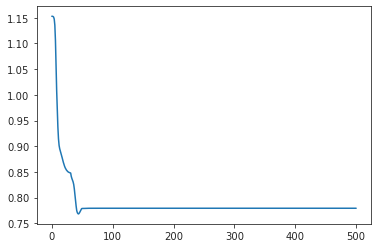

In [57]:
plt.plot(selected_run['valid']['nll'])

In [58]:
base = Base(mice, num_k, key, 'ca2')
tr = base.project_vec(selected_run['pi'])
tr = base.trim2d(tr)

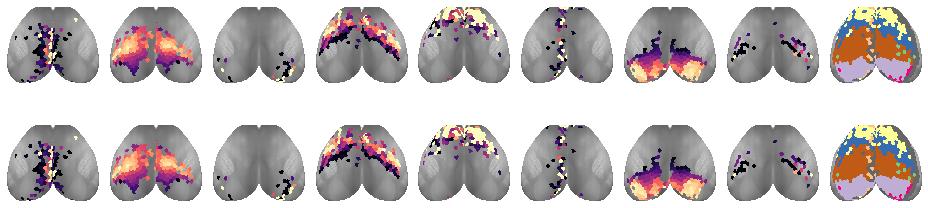

In [59]:
quick_show(tr, tr)

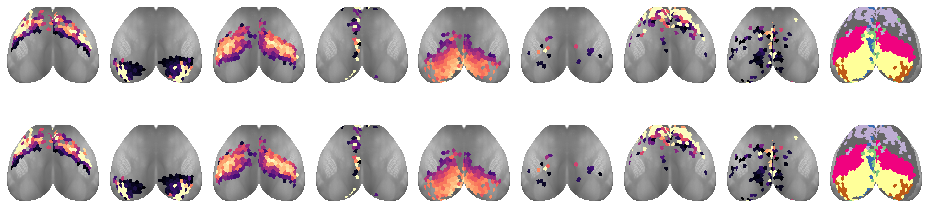

In [65]:
selected_pi = {}
for key in mice.ca:
    sv = SVINET(mice, num_k, perc, key, 'ca2', verbose=False)
    _ = sv.load_runs()
    last_perf = collections.defaultdict(list)
    for run_name, run_dict in sv._runs[sv.perc].items():
        for lbl, vals in run_dict['valid'].items():
            if 'nll' not in lbl:
                continue
            last_perf[lbl].append(run_dict['valid'][lbl][-1])
    rank_perf = {lbl: sp_stats.rankdata(x) for lbl, x in last_perf.items()}
    x = np.concatenate([x.reshape(1, -1) for x in rank_perf.values()]).mean(0)
    best = np.argmax(x)
    selected_run = list(sv._runs[sv.perc].values())[best]
    selected_pi[key] = selected_run['pi']

In [66]:
len(selected_pi)

154

In [78]:
gr = Group(mice, mode='ca2')

In [81]:
pi_all = np_nans((10, 3, 4, num_k, len(gr.n2l)))
for key, (sub, ses, run) in mice.looper.items():
    x = selected_pi.get(key)
    if x is None:
        continue
    
    x /= np.nansum(x, -2, keepdims=True)
    
    if run in [1, 2]:
        run_i = 0
    elif run in [3, 4]:
        run_i = 1
    elif run in [5, 6]:
        run_i = 2
    else:
        run_i = 3
    pi_all[sub - 1, ses - 1, run_i] = x

In [83]:
good_runs, good_global = gr._good_nodes(pi_all, 0.95)
len(good_runs), len(good_global)

(60, 337)

In [87]:
data = []
for i, j, k in good_runs:
    data.append(pi_all[i, j, k][:, good_global])
data = np.concatenate(data)
data.shape

(480, 337)

In [91]:
centroids = np.zeros((num_k, pi_all.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data,
    n_clusters=num_k,
    match_metric='euclidean',
    random_state=42,
)
centroids[:, good_global] = _centroids

In [92]:
global_mapping = gr.align_centroid_to_structs(
    pi_mv=centroids,
    metric=gr.dist_metric,
    global_order=gr.global_order,
)
centroids = centroids[global_mapping]

In [95]:
_pi = centroids / np.nansum(centroids, -2, keepdims=True)
tr = gr.project_vec(_pi)
tr = gr.trim2d(tr)

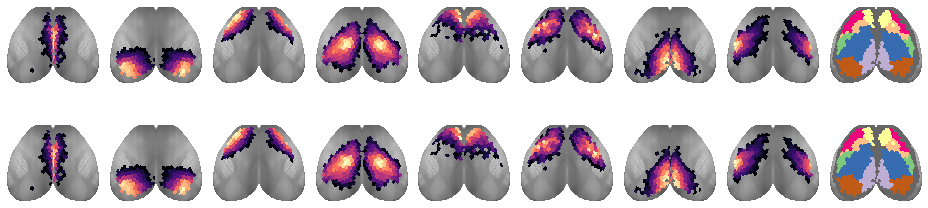

In [96]:
quick_show(tr, tr)

In [101]:
ner = Normalizer()
perms = {}
for k, x in selected_pi.items():
    good = np.where(np.isnan(x).sum(0) == 0)[0]
    good = set(good).intersection(good_global)
    good = np.array(sorted(good))
    _x = x[..., good]
    _x = np.where(~np.isnan(_x), _x, 0.0)

    perms[k] = find_best_mappings(
        data={0: ner.fit_transform(_x)},
        centroids=ner.fit_transform(centroids[:, good]),
        match_metric=gr.dist_metric,
        global_order=True,
    )[0]

In [106]:
pi_final = []
for k, gmap in perms.items():
    pi_final.append(np.expand_dims(selected_pi[k][list(gmap.values())], 0))
pi_final = np.concatenate(pi_final)
pi_final.shape

(154, 8, 542)

In [107]:
pi = bn.nanmean(pi_final, 0)
tr_final = gr.project_vec(pi)
tr_final = gr.trim2d(tr_final)

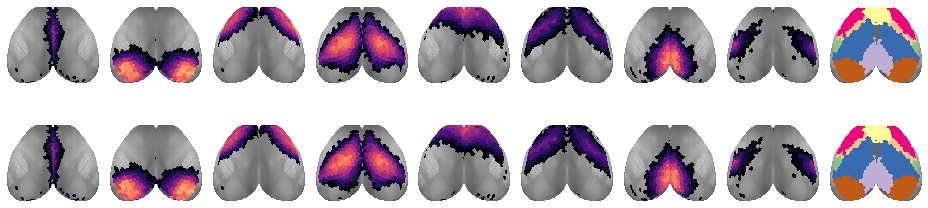

In [109]:
quick_show(tr_final, tr_final, vmin=0.1, vmax=0.8)

## Prepare

### k = 8, p = 24

In [4]:
mice = Mice(512)
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 8, 24
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [5]:
%%time

gr_ca = Group(**props_ca).fit_group(force=True)
gr_bo = Group(**props_bo).fit_group(force=True)

CPU times: user 9min 24s, sys: 27 s, total: 9min 51s
Wall time: 1min 53s


In [6]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [7]:
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

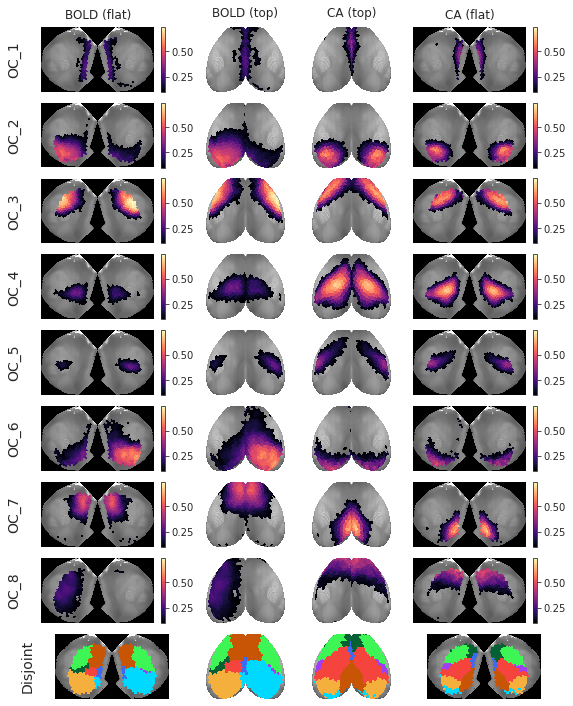

In [8]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [17]:
idx = 5
pi = gr_bo.pi.copy()
pi[1] *= 0.5
pi[idx] *= 0.5

#pi[1][pi[1] < 0.1] = 0
#pi[4][pi[4] < 0.1] = 0
pi[1] += pi[idx]
pi = pi[np.delete(range(num_k), idx)]
pi = pi / np.nansum(pi, -2, keepdims=True)
pi = pi#[[4, 1, 2, 3, 0, 5, 6]]
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [26]:
pi_ca = gr_ca.pi[[0, 5, 2, 3, 4, 7, 6, 1]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

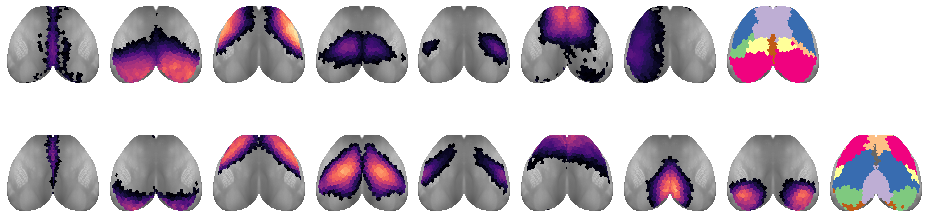

In [27]:
quick_show(tr, tr_ca, vmin=0.12, vmax=0.8)

In [28]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca, 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca, 'correlation'))

sim_corr.diagonal().mean(), sim_cos.diagonal().mean()

(0.6017572905565334, 0.8030669925579507)

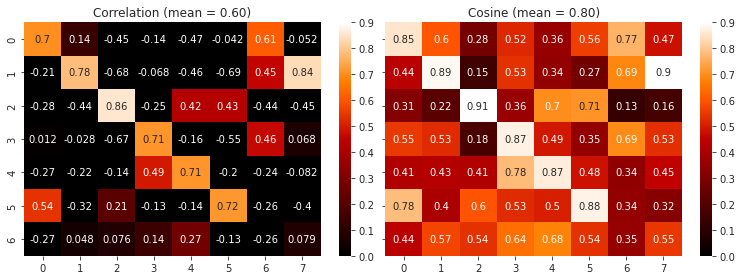

In [29]:
fig, axes = create_figure(1, 2, (10.7, 4), 'all', 'all')
sns.heatmap(sim_corr, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[0])
sns.heatmap(sim_cos, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[1])
axes[0].set_title(f'Correlation (mean = {sim_corr.diagonal().mean():0.2f})')
axes[1].set_title(f'Cosine (mean = {sim_cos.diagonal().mean():0.2f})')
plt.show()

In [30]:
gmap = find_best_match(sim_corr)
gmap = list(gmap.values())
gmap += [i for i in range(len(pi_ca)) if i not in gmap]
gmap

[0, 7, 2, 3, 4, 5, 1, 6]

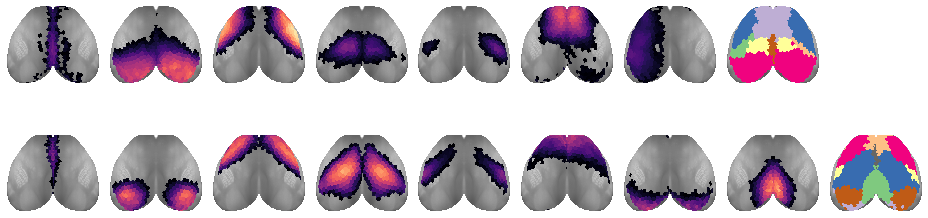

In [31]:
quick_show(
    tr,
    gr_ca.trim2d(gr_ca.project_vec(pi_ca[gmap])),
    vmin=0.12,
    vmax=0.8,
)

In [32]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'correlation'))

sim_corr.diagonal().mean(), sim_cos.diagonal().mean()

(0.654164572319145, 0.8357039746985614)

### k = 8, p = 25

In [33]:
mice = Mice(512)
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 8, 25
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [34]:
%%time

gr_ca = Group(**props_ca).fit_group(force=True)
gr_bo = Group(**props_bo).fit_group(force=True)

CPU times: user 7min 30s, sys: 27.7 s, total: 7min 58s
Wall time: 1min 46s


In [35]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [36]:
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

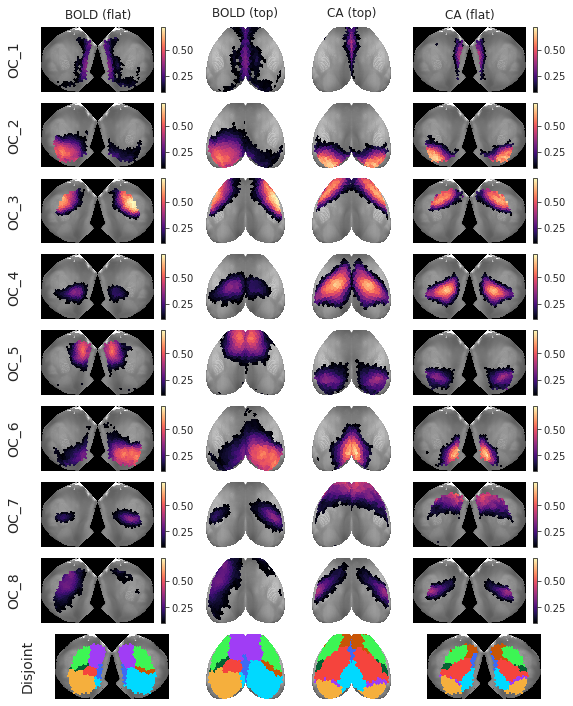

In [37]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [38]:
idx = 5
pi = gr_bo.pi.copy()
pi[1] *= 0.5
pi[idx] *= 0.5

#pi[1][pi[1] < 0.1] = 0
#pi[4][pi[4] < 0.1] = 0
pi[1] += pi[idx]
pi = pi[np.delete(range(num_k), idx)]
pi = pi / np.nansum(pi, -2, keepdims=True)
pi = pi[[4, 1, 2, 3, 0, 5, 6]]
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [39]:
pi_ca = gr_ca.pi[[6, 1, 2, 3, 0, 7, 5, 4]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

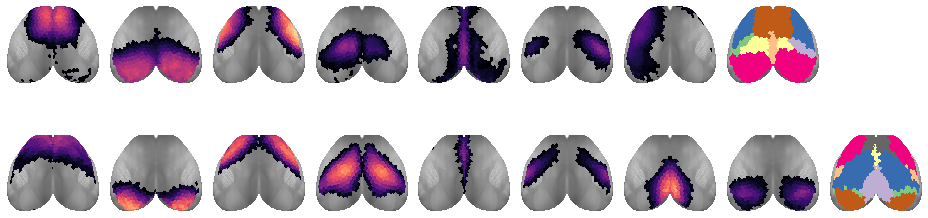

In [40]:
quick_show(tr, tr_ca, vmin=0.12, vmax=0.8)

In [41]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca, 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca, 'correlation'))

sim_corr.diagonal().mean(), sim_cos.diagonal().mean()

(0.5665122019701242, 0.7877928879321429)

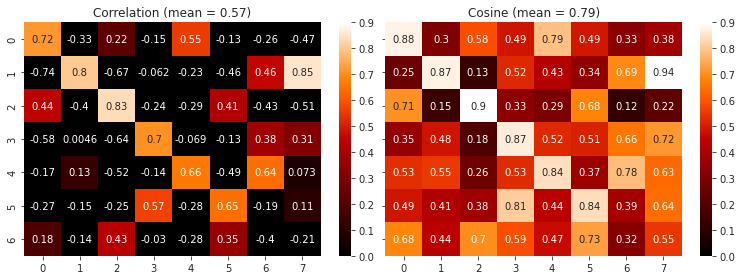

In [42]:
fig, axes = create_figure(1, 2, (10.7, 4), 'all', 'all')
sns.heatmap(sim_corr, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[0])
sns.heatmap(sim_cos, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[1])
axes[0].set_title(f'Correlation (mean = {sim_corr.diagonal().mean():0.2f})')
axes[1].set_title(f'Cosine (mean = {sim_cos.diagonal().mean():0.2f})')
plt.show()

In [43]:
gmap = find_best_match(sim_corr)
gmap = list(gmap.values())
gmap += [i for i in range(len(pi_ca)) if i not in gmap]
gmap

[0, 7, 2, 3, 4, 5, 1, 6]

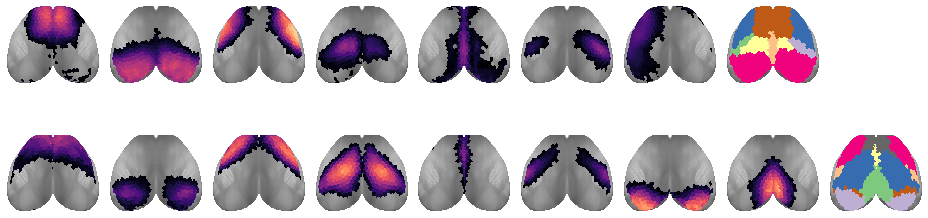

In [44]:
quick_show(
    tr,
    gr_ca.trim2d(gr_ca.project_vec(pi_ca[gmap])),
    vmin=0.12,
    vmax=0.8,
)

In [45]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'correlation'))

sim_corr.diagonal().mean(), sim_cos.diagonal().mean()

(0.6113043423079244, 0.814767499100144)

## CONT: what if I took the top seed?